### Check optimization sequence aiming at mean $n_z$

In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt
from tqdm import tqdm
M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Trace cold molecule

In [18]:
import numpy as np
import cupy as cp

# --- run your sim (as you already do) ---
seq_partial = np.load("../partial_cooling_amp/seq_partial.npy")

temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules(10000, temp, detuning_sigma=0)
mol_copy = mol_0.copy()

cr.raman_cool_with_pumping(
    mol_0,
    seq_partial,
    res,
    show_progress=True
)


Raman pulses: 100%|██████████| 200/200 [00:45<00:00,  4.41it/s]


Selected molecules: 2030


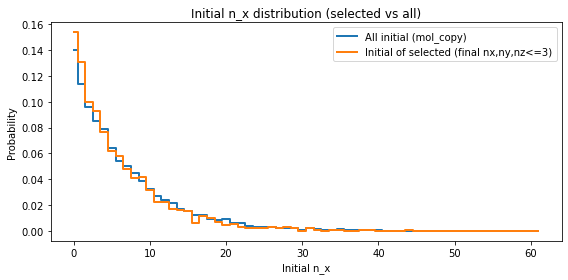

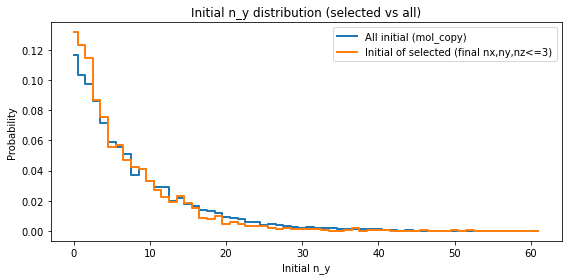

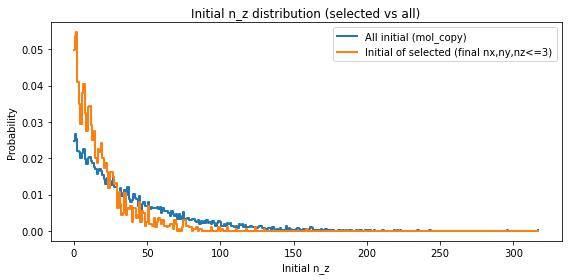

In [19]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

# --- helper: GPU bincount -> normalized PDF on CPU ---
def pdf_from_cp_int(arr: cp.ndarray, max_n: int) -> np.ndarray:
    if arr.size == 0:
        return np.zeros((0,), dtype=float)
    if max_n is None:
        max_n = int(arr.max().get())
    bc = cp.bincount(arr.astype(cp.int32), minlength=max_n + 1).astype(cp.float64)
    s = float(bc.sum().get())
    return (bc.get() / s) if s > 0 else np.zeros((max_n + 1,), dtype=float)

# --- 1) selection on FINAL mol_0 ---
mask_final = (
    (mol_0[:, 5] == 0) &          # not lost
    (mol_0[:, 0] <= 3) &
    (mol_0[:, 1] <= 3) &
    (mol_0[:, 2] <= 3)
)
idx = cp.where(mask_final)[0]
print("Selected molecules:", int(idx.size))

# --- 2) initial vibrational numbers for selected set ---
init_sel_x = mol_copy[idx, 0].astype(cp.int32)
init_sel_y = mol_copy[idx, 1].astype(cp.int32)
init_sel_z = mol_copy[idx, 2].astype(cp.int32)

# --- 3) initial vibrational numbers for ALL molecules ---
all_x = mol_copy[:, 0].astype(cp.int32)
all_y = mol_copy[:, 1].astype(cp.int32)
all_z = mol_copy[:, 2].astype(cp.int32)

# choose a shared max for each axis so bins match
max_x = int(cp.max(cp.stack([all_x.max(), init_sel_x.max() if init_sel_x.size else all_x.max()])).get())
max_y = int(cp.max(cp.stack([all_y.max(), init_sel_y.max() if init_sel_y.size else all_y.max()])).get())
max_z = int(cp.max(cp.stack([all_z.max(), init_sel_z.max() if init_sel_z.size else all_z.max()])).get())

# PDFs
pdf_all_x = pdf_from_cp_int(all_x, max_x)
pdf_sel_x = pdf_from_cp_int(init_sel_x, max_x)

pdf_all_y = pdf_from_cp_int(all_y, max_y)
pdf_sel_y = pdf_from_cp_int(init_sel_y, max_y)

pdf_all_z = pdf_from_cp_int(all_z, max_z)
pdf_sel_z = pdf_from_cp_int(init_sel_z, max_z)

def plot_overlay(pdf_all, pdf_sel, axis_name):
    n = np.arange(len(pdf_all))
    plt.figure(figsize=(8, 4))
    plt.step(n, pdf_all, where="mid", linewidth=2, label="All initial (mol_copy)")
    plt.step(n, pdf_sel, where="mid", linewidth=2, label="Initial of selected (final nx,ny,nz<=3)")
    plt.xlabel(f"Initial n_{axis_name}")
    plt.ylabel("Probability")
    plt.title(f"Initial n_{axis_name} distribution (selected vs all)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_overlay(pdf_all_x, pdf_sel_x, "x")
plot_overlay(pdf_all_y, pdf_sel_y, "y")
plot_overlay(pdf_all_z, pdf_sel_z, "z")


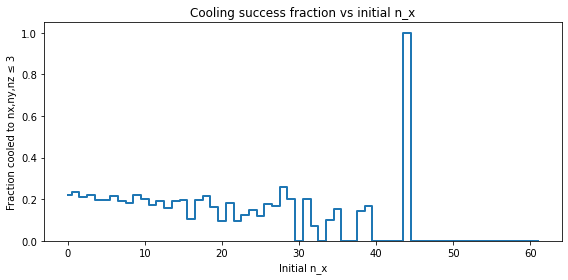

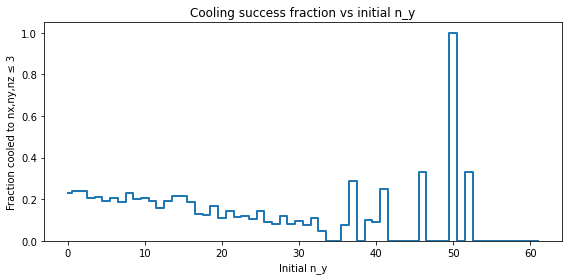

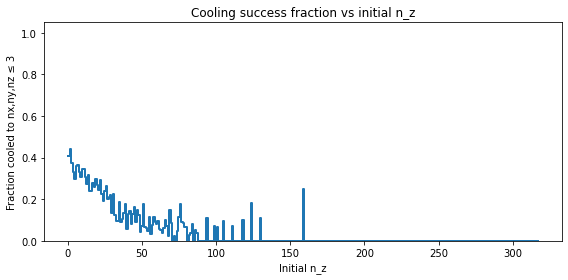

In [20]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

# Final success condition: cooled to nx,ny,nz <= 3 (and not lost)
success = (
    (mol_0[:, 5] == 0) &
    (mol_0[:, 0] <= 3) &
    (mol_0[:, 1] <= 3) &
    (mol_0[:, 2] <= 3)
)

def frac_success_by_initial_n(init_n: cp.ndarray, success_mask: cp.ndarray) -> np.ndarray:
    """
    For each initial n value, compute fraction that succeed.
    Returns CPU numpy array frac[n] for n=0..nmax
    """
    init_n = init_n.astype(cp.int32)
    nmax = int(init_n.max().get()) if init_n.size else 0

    # total count per initial n
    total = cp.bincount(init_n, minlength=nmax + 1).astype(cp.float64)

    # successful count per initial n
    succ = cp.bincount(init_n[success_mask], minlength=nmax + 1).astype(cp.float64)

    frac = cp.where(total > 0, succ / total, 0.0)
    return frac.get()

# Initial n arrays (from mol_copy)
init_x = mol_copy[:, 0]
init_y = mol_copy[:, 1]
init_z = mol_copy[:, 2]

frac_x = frac_success_by_initial_n(init_x, success)
frac_y = frac_success_by_initial_n(init_y, success)
frac_z = frac_success_by_initial_n(init_z, success)

def plot_frac(frac: np.ndarray, axis_name: str):
    n = np.arange(len(frac))
    plt.figure(figsize=(8, 4))
    plt.step(n, frac, where="mid", linewidth=2)
    plt.ylim(0, 1.05)
    plt.xlabel(f"Initial n_{axis_name}")
    plt.ylabel("Fraction cooled to nx,ny,nz ≤ 3")
    plt.title(f"Cooling success fraction vs initial n_{axis_name}")
    plt.tight_layout()
    plt.show()

plot_frac(frac_x, "x")
plot_frac(frac_y, "y")
plot_frac(frac_z, "z")
